## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.



#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.



### Libraries

In [18]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import warnings

from networkx.algorithms import bipartite
from pandas.plotting import scatter_matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

warnings.filterwarnings('ignore', category=DeprecationWarning)

### Read data

In [204]:
df = pd.read_csv('lalonde.csv',index_col=0)
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Analysing the dataset, we find out that there are no missing values and that there are some attributes(`treat`, `black`, `hispan`, `married` and `nodegree`) that are categorical, so we convert this to a category type.

In [205]:
# Polishing columns
df['race'] = 1 * df.black + 2 * df.hispan
df['race'] = df['race'].replace([0,1,2], ['White', 'Black', 'Hispanic'])
df['race'] = df.race.astype('category')
df = df.drop('black', 1)
df = df.drop('hispan', 1)
df['treat'] = df.treat.astype('category')
df['married'] = df.married.astype('category')
df['nodegree'] = df.nodegree.astype('category')

# Renaming of the columns
df = df.rename(columns={
    'treat':'Treatment',
    'age':'Age',
    'educ':'Education',
    'married':'Married',
    'nodegree':'No degree',
    'race':'Race'
    }
)

df.head()

,Treatment,Age,Education,Married,No degree,re74,re75,re78,Race
id,,,,,,,,,
NSW1,1,37,11,1,1,0.0,0.0,9930.0460,Black
NSW2,1,22,9,0,1,0.0,0.0,3595.8940,Hispanic
NSW3,1,30,12,0,0,0.0,0.0,24909.4500,Black
NSW4,1,27,11,0,1,0.0,0.0,7506.1460,Black
NSW5,1,33,8,0,1,0.0,0.0,289.7899,Black


### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?


#### Plot analysis
We divide the initial data set into two groups, the group of people that received additional job training and the group that did not.

In [206]:
#divide the two groups and plot
treat = df[df.Treatment == 1]
notreat = df[df.Treatment == 0]

We first plot, using histograms, the distribution of the variable re78 in the two groups.

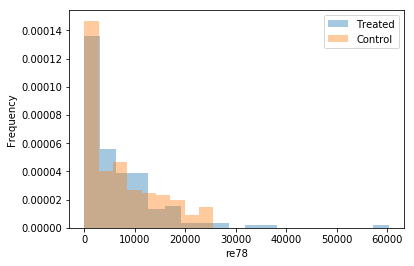

In [181]:
def plot_dist_comparison(df, attribute, treated=(df.Treatment == 1), 
                         control=(df.Treatment == 0)):
    sns.distplot(norm_hist=True, kde=False, a=df[treated][[attribute]], label='Treated')
    sns.distplot(norm_hist=True, kde=False, a=df[control][[attribute]], label='Control')
    plt.ylabel('Frequency')
    plt.xlabel(attribute)
    plt.legend()
    return plt.gca()

plot_dist_comparison(df, 're78')
plt.show()

We notice that the distribution of the two groups has a similar shape, resembling an exponential distribution. We also see that in proportion there are more individuals with a very low income (0 or close to 0) in the control group, whereas the treatment group has several outliers (income higher than 25000$).

However, it is difficult to compare distributions using only histogram due to the large scale of values that features can posses. This can make histograms hardly readable in certain situations. Furthermore, histograms don't give us any idea about how many people have an income under or over a certain threshold.

We decide to proceed with the use of boxplots in order to show more information.

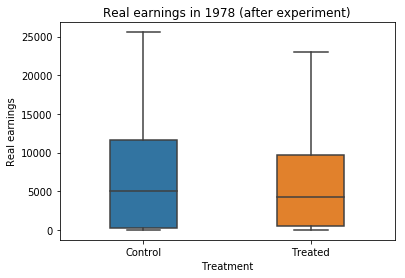

In [100]:
fig = sns.boxplot(x=df.Treatment,y=df.re78, width=0.4, showfliers=False)
fig.set_xticklabels(['Control', 'Treated'])
fig.set_ylabel('Real earnings')
fig.set_title('Real earnings in 1978 (after experiment)')
plt.show()

Box plot above with removed outliers reagarding real earnings in 1978 give us a better understanding of the earnings data. We observe that median value has not changed siginificantly, and that, maybe suprisingly, group that did not receive treatment experiences higher average earnings value. Furthermore, we observe that group that did not receive treatment experiences higher variance in the data.

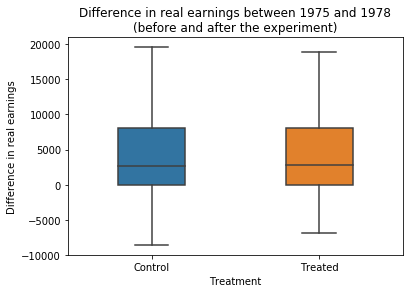

In [106]:
fig = sns.boxplot(x=df.Treatment,y=df.re78-df.re75, width=0.4, showfliers=False)
fig.set_xticklabels(['Control', 'Treated'])
fig.set_ylabel('Difference in real earnings')
fig.set_title('Difference in real earnings between 1975 and 1978'
              +'\n(before and after the experiment)')
plt.show()

Another boxplot, this time depicting the difference in real earnings between 1975 and 1978, further points to the conclusion that treatment did not result in the significant (if any) rise in the treated workers' salaries, compared to those of the control group.

#### Why are approaches presented above superficial
The approaches outlined above are superficial since we are approaching the treatment groups from a very high level of abstraction: we are separating participants in those who received and those who did not receive the treatment. Original data provide us with several categories that significantly granulate the data, and proper research on the effectiveness of the treatment should explore more meaningful groups constructed from these categories.

### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.


#### Insight into our approach

We will approach per-feature distribution analysis first through exploration of numerical variables, and then categorical variables. Distributions of numerical variables will be explored through comparative histograms and boxplots, which should provide us with a meaningful comparative overview of variable distributions. Moreover, categorical variables will be explored through more appropriate side-by-side count plots.

#### Numerical variable analysis

We will try to observe whether some numerical variable experiences difference in the distribution that might point to that variable being part of the selection criteria for the treatment group.

#### Real earnings for the year 1974

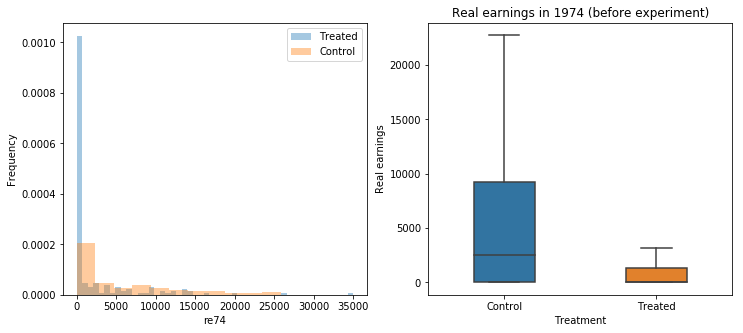

In [229]:
def plot_dist_and_box(df_, attr, ylabel, title, filter_=None):
    if filter_ is not None:
        df_ = df_[filter_]

    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    plt.subplot(1, 2, 1)
    plot_dist_comparison(df_, attr)

    plt.subplot(1, 2, 2)
    fig = sns.boxplot(x=df_.Treatment,y=df_[attr], width=0.4, showfliers=False)
    fig.set_xticklabels(['Control', 'Treated'])
    fig.set_ylabel(ylabel)
    fig.set_title(title)

plot_dist_and_box(df, 're74', 'Real earnings', 'Real earnings in 1974 (before experiment)')
plt.show()

#### Real earnings for the year 1975

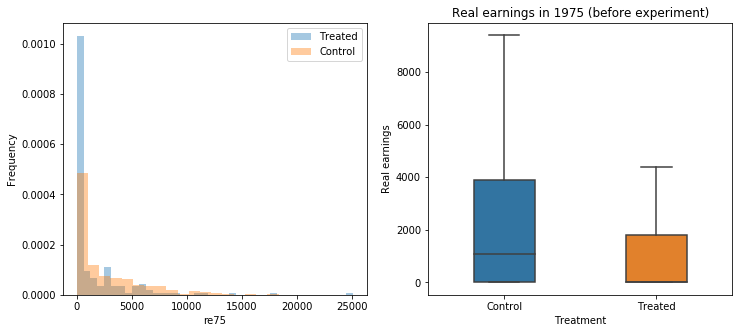

In [169]:
plot_dist_and_box(df, 're75', 'Real earnings', 'Real earnings in 1975 (before experiment)')
plt.show()

#### Age

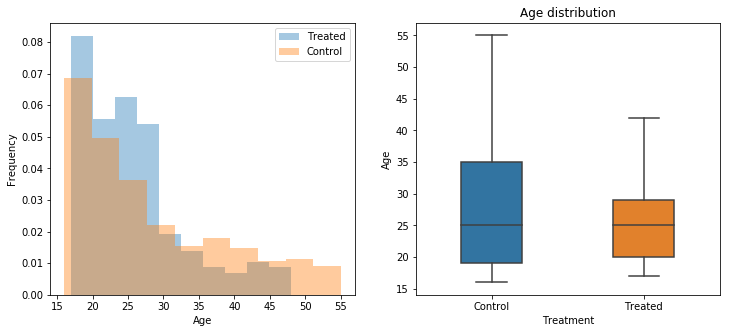

In [170]:
plot_dist_and_box(df, 'Age', 'Age', 'Age distribution')
plt.show()

#### Education

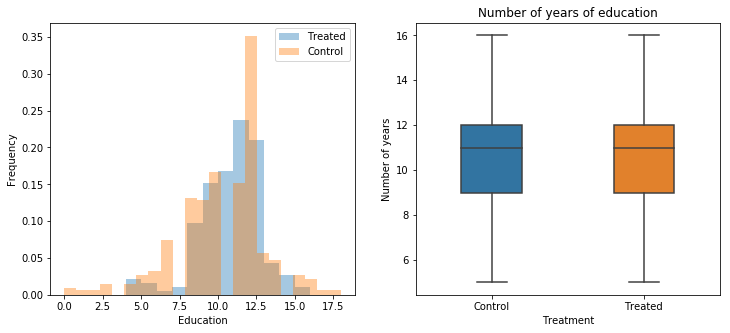

In [171]:
plot_dist_and_box(df, 'Education', 'Number of years', 'Number of years of education')
plt.show()

Distribution of participants by their years of education seem to be relatively similar. This points to the conclusion that the number of years spent on education was not the selection criteria.

#### Categorical variables analysis

We will try to observe whether some category experiences difference in the distribution that might point to that category being part of the selection criteria for the treatment group.

#### Race

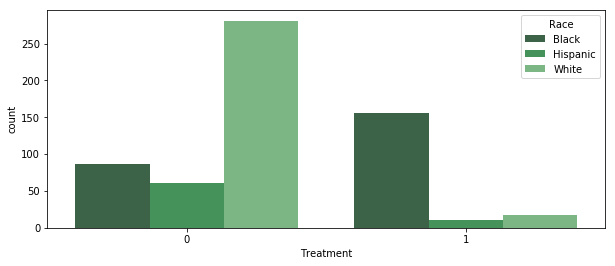

In [190]:
def plot_race(df_):
    fig, axes = plt.subplots(1, 1, figsize=(10, 4))
    sns.countplot(hue='Race', x='Treatment', data=df_, palette='Greens_d')

plot_race(df)
plt.show()

We observe that black people seem to be favored in the program. This might have been one of the selection criteria, and presents positive discrimination.

#### Marriage status & Possesion of a degree

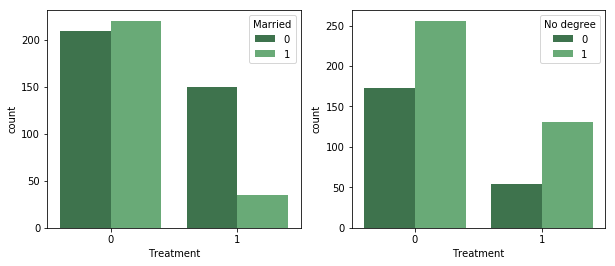

In [216]:
def plot_marr_deg(df_):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(hue='Married', x='Treatment', data=df, palette='Greens_d')
    plt.subplot(1, 2, 2)
    sns.countplot(hue='No degree', x='Treatment', data=df, palette='Greens_d')

plot_marr_deg(df)
plt.show()


age similar mean different quartiles all under fifty and more dense between 20-30
educ similar quartiles but it seems like they just remove outliers
re74re75 mean in treat group very close to 0 while other group still low but higher (3rd treat similar mean no treat)
re75 a 3rd e 90 a little higher but still lower than other group....present many outliers

We observe that people that are not married seem to be favored in the program.

Even though the purpose of the training program is to help participants find jobs and have better salaries, education level does not seem to be the prevailing selection criteria for the program. In general, more participants of the program are without the degree.

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)


In [234]:
# Create dummmy for categorical race variable
race_dummy = pd.get_dummies(df.Race)
X = pd.concat([df, race_dummy], axis=1)
X = X.drop(['Treatment', 're78', 'Race'], axis=1)
y = df.Treatment
logistic = LogisticRegression() # create the model
logistic.fit(X, y)  # train it
X.head()

,Age,Education,Married,No degree,re74,re75,Black,Hispanic,White
id,,,,,,,,,
NSW1,37,11,1,1,0.0,0.0,1,0,0
NSW2,22,9,0,1,0.0,0.0,0,1,0
NSW3,30,12,0,0,0.0,0.0,1,0,0
NSW4,27,11,0,1,0.0,0.0,1,0,0
NSW5,33,8,0,1,0.0,0.0,1,0,0


For the regressor matrix we can obviously drop 'Treatment', since this is the variable we want to predict. We can also drop 're78', since the probability should only depend on prior knowledge. Finally, we also drop 'Race', as we have replaced it with a dummy variable.

In [222]:
# Get probabilities
pred = logistic.predict_proba(X)
df_pred = df.copy()
df_pred['prob_treat'] = pred[:,0]
df_pred.head()

,Treatment,Age,Education,Married,No degree,re74,re75,re78,Race,prob_treat
id,,,,,,,,,,
NSW1,1,37,11,1,1,0.0,0.0,9930.0460,Black,0.487237
NSW2,1,22,9,0,1,0.0,0.0,3595.8940,Hispanic,0.706139
NSW3,1,30,12,0,0,0.0,0.0,24909.4500,Black,0.351450
NSW4,1,27,11,0,1,0.0,0.0,7506.1460,Black,0.332523
NSW5,1,33,8,0,1,0.0,0.0,289.7899,Black,0.336496


#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?



In [223]:
B = nx.Graph()
treat_1 = df_pred.loc[df_pred.Treatment == 1]
treat_0 = df_pred.loc[df_pred.Treatment == 0]

# create edges
edges = []
for (i, (id_i, entry_1)) in enumerate(treat_1.iterrows()):
    for (j, (id_j, entry_0)) in enumerate(treat_0.iterrows()):
        # make weight negative to use max_weight_matching algorithm
        weight = 1 - abs(entry_1['prob_treat'] - entry_0['prob_treat'])
        edges.append((id_i, id_j, weight))

# Add nodes with the node attribute "bipartite"
B.add_nodes_from(treat_1.index, bipartite=0)
B.add_nodes_from(treat_0.index, bipartite=1)
# Add edges
B.add_weighted_edges_from(edges)

A bipartite graph $B$ is created, containing the control group as nodes in one disjoint set ($X$), and the treated group in the other ($Y$). Edges are added such that every node in $X$ is connected to every node in $Y$, and the weight of the respective edge is one minus the absolute difference between the probabilities of the nodes it connects. We then apply the max_weight_matching to obtain a matching that effectively minimizes the sum of all weights.

In [224]:
matching = nx.max_weight_matching(B, maxcardinality=True)

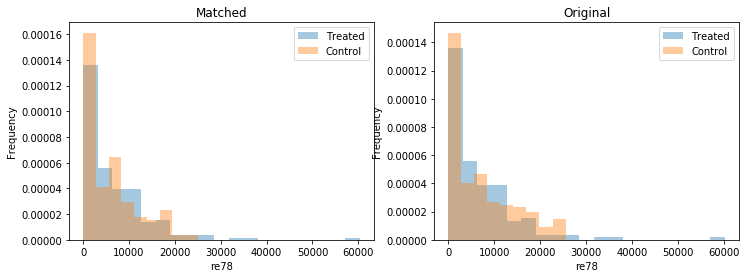

In [238]:
# Only keep matches in one direction
reduced = {k : v for k, v in matching.items() if k in set(treat_1.index)}

# Plot new distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_dist_comparison(df, 're78', df.index.isin(reduced.keys()),
                     df.index.isin(reduced.values())).set_title('Matched')

plt.subplot(1, 2, 2)
# as a reminder, the original plot
plot_dist_comparison(df, 're78').set_title('Original')
plt.show()

/home/joey/.conda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/joey/.conda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


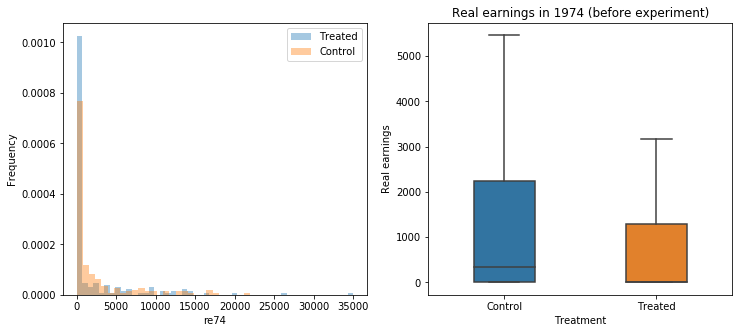

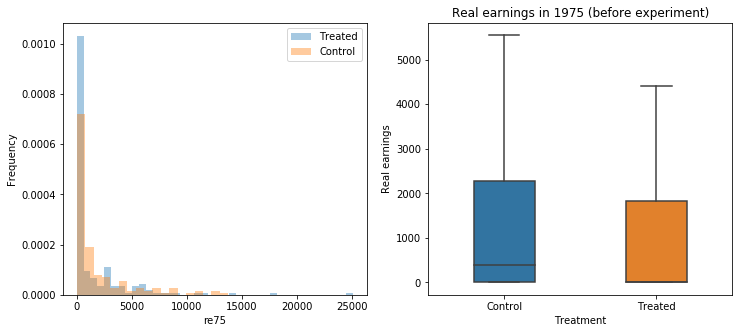

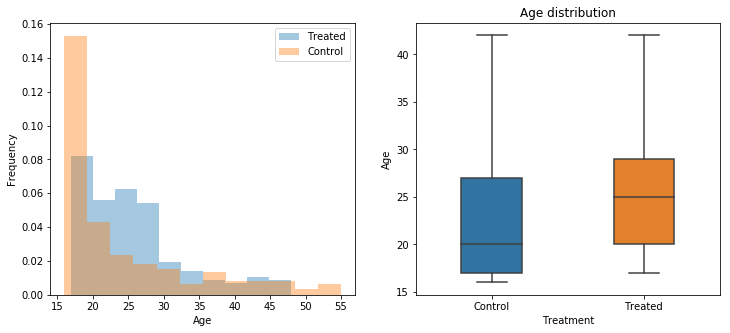

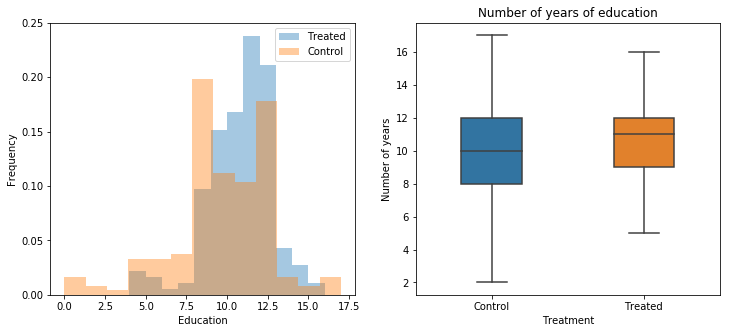

In [230]:
filter_ = df.index.isin(set(reduced.keys()).union(set(reduced.values())))

plot_dist_and_box(df, 're74', 'Real earnings', 
                  'Real earnings in 1974 (before experiment)', filter_)
plot_dist_and_box(df, 're75', 'Real earnings', 
                  'Real earnings in 1975 (before experiment)', filter_)
plot_dist_and_box(df, 'Age', 'Age', 'Age distribution', filter_)
plot_dist_and_box(df, 'Education', 'Number of years', 
                  'Number of years of education', filter_)
plt.show()

370

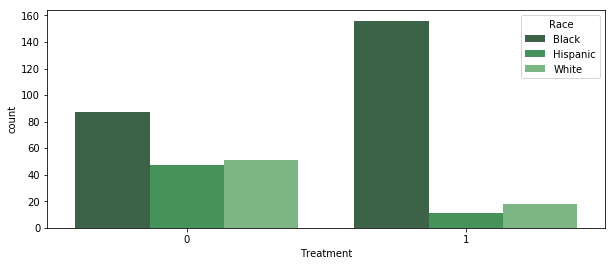

In [242]:
plot_race(df[filter_])

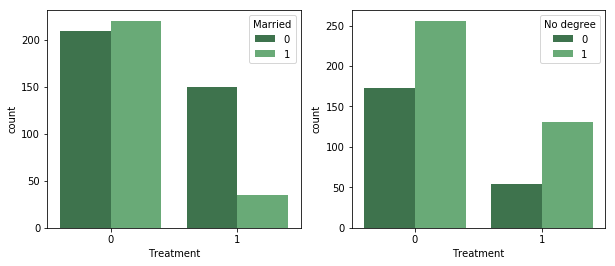

In [228]:
plot_marr_deg(df[filter_])

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [59]:
B_impr = nx.Graph()
treat_1 = df_pred.loc[df_pred.treat==1]
treat_0 = df_pred.loc[df_pred.treat==0]

# Add nodes with the node attribute "bipartite"
B_impr.add_nodes_from(treat_1.index, bipartite=0)
B_impr.add_nodes_from(treat_0.index, bipartite=1)

# Add edges
edges = []
for (i, (id_i, entry_1)) in enumerate(treat_1.iterrows()):
    for (j, (id_j, entry_0)) in enumerate(treat_0.iterrows()):
        # make weight negative to use max_weight_matching algorithm
        if entry_1['Black'] == entry_0['Black'] and\
            entry_1['No degree'] == entry_0['No degree']:
            weight = 1 - abs(entry_1['prob_treat'] - entry_0['prob_treat'])
            edges.append((id_i, id_j, weight))

B_impr.add_weighted_edges_from(edges)

In [60]:
matching_impr = nx.max_weight_matching(B_impr, maxcardinality=True)

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?


In [ ]:
# Only keep matches in one direction
reduced_impr = {k : v for k, v in matching_impr.items() if k in set(treat_1.index)}

# Plot new distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_dist_comparison(df, 're78', df.index.isin(reduced.keys()),
                     df.index.isin(reduced.values())).set_title('Matched Improved')

plt.subplot(1, 2, 2)
# as a reminder, the original plot
plot_dist_comparison(df, 're78').set_title('Original')
plt.show()

In [ ]:
filter_imp = df.index.isin(set(reduced.keys()).union(set(reduced.values())))
plot_dist_and_box(df, 're74', 'Real earnings', 
                  'Real earnings in 1974 (before experiment)', filter_imp)
plot_dist_and_box(df, 're75', 'Real earnings', 
                  'Real earnings in 1975 (before experiment)', filter_imp)
plot_dist_and_box(df, 'Age', 'Age', 'Age distribution', filter_imp)
plot_dist_and_box(df, 'Education', 'Number of years', 
                  'Number of years of education', filter_imp)
plt.show()

In [ ]:
plot_race(df[filter_imp])

In [ ]:
plot_marr_deg(df[filter_])

## Assignment 2 - Applied Machine Learning

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)). [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency-inverse document frequency, is of great help when if comes to computation of textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

#### Obtaining data and constructing TF-IDF matrix

20newsgroup data set is a classic data set that can be obtained directly through `sklearn`. Following data download, we immediately obtain TF-IDF matrix from the available corpus. TF-IDF vectorizer has been configured to ignore  English stopwords. Furthermore, we instruct the vectorizer to ignore words whose frequency is below the threshold equal to `1e-4`, and above the threshold equal to `0.5`. Argument for ignoring words with low frequency is that we don't want our classifier to be trained on specific terms that are not unique to categories, but are instead words specific to vocabulary used in some articles, and will not extend well to generalization. Furthermore, argument for ignoring words with high frequency is that we want to ignore those words that are frequently used when writing news articles in general, and do not provide relevant information for generalization.

*Disclaimer:* values utilized in TF-IDF vectorization configuration encompas our findings discovered through several runs of random forest classifier training, and research on TF-IDF vectorization.

In [38]:
news_groups = fetch_20newsgroups(subset='all')

vectorizer = TfidfVectorizer(sublinear_tf = True, min_df = 0.0001, max_df = 0.5, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(news_groups.data)

tfidf_matrix

<18846x75560 sparse matrix of type '<class 'numpy.float64'>'
	with 1966301 stored elements in Compressed Sparse Row format>

#### Data split

With sklearn's `train_test_split` function we split our data set in the training portion containing 90% of the original data, and testing portion containing 10% of the original data.

In [39]:
X, X_test, y, y_test = train_test_split(tfidf_matrix, news_groups.target, test_size=0.10, random_state=55)

We will not further split our training data to obtain validation set, because we will leverage sklearn's `GridSearchCV`.

#### Training phase

`GridSearchCV` object performs exhaustive search over specified parameter values for an estimator. After initial configuration where estimator and parameters are provided, as well as size of `k` folding, function trains (fits) different models of estimator with the call to `fit` function to which we pass data which we designated for training phase. Finally, model of estimator with the best parameters is used to predict values on the portion of the data which we designated for the training phase.

We opted for the 'k-folding' approach integrated in the `GridSearchCV` object to prevent bias and knowledge leak that can occurr with the predefined selection of validation set. Furthermore, we believe that k-folding apporach will provide us with more robust accuracy estimation, since the performance measure reported by k-fold cross-validation is the average of the performance measurements computed in the loop when applying every data fold.

*Note:* Training done in the following phase lasts fair ammount of time due to exhaustive search over parameter values for random forest estimator. Best estimator that we were able to obtain has been saved to pickle file, and can be used for future predictions. Due to GitHub's limit on upload file size, our best estimator pickle file can be found [here](https://drive.google.com/open?id=1rR1jJTMw5aXvbmNQBUnzF9ZTt1d4nAPc) (Google Drive folder with public access) for testing.

In [13]:
rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt', oob_score=True) 

# Use a grid over parameters of interest
param_grid = { 
    'n_estimators':[100, 200, 300, 500],
    'max_depth':[80, 160, 240, 320]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 300, 500], 'max_depth': [80, 160, 240, 320]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

#### Saving best estimator for future use

In [40]:
with open('best_estimator.pkl', 'wb') as fp:
    pickle.dump(CV_rfc.best_estimator_, fp)

#### Loading previously obtained best estimator

In [41]:
with open('best_estimator.pkl', 'rb') as fp:
    best_estimator = pickle.load(fp)

#### Validation phase

With the training phase done, we will now evaluate performance of our best estimator model on the test data, with resulting model accuracy and confusion matrix provided below.

Classifier accuracy 0.863129973474801
Tree depth of the best classifier: 320
Number of trees in the forest for best classifier: 500
Most important feature: 0.00739766450310256
Number of features with nonzero importance: 62916
Percentage of features with nonzero importance: 83.26627845420857


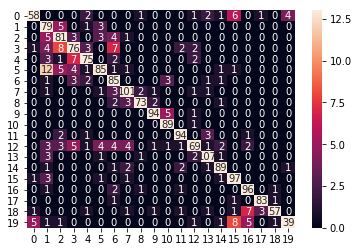

In [42]:
y_pred = best_estimator.predict(X_test)
accuracy = 1 - np.sum(y_test != y_pred) / len(y_test)
feat_imp = best_estimator.feature_importances_

print("Classifier accuracy {0}".format(accuracy))
print("Tree depth of the best classifier: {0}".format(best_estimator.max_depth))
print("Number of trees in the forest for best classifier: {0}".format(best_estimator.n_estimators))
print("Most important feature: {0}".format(np.max(feat_imp)))
print("Number of features with nonzero importance: {0}".format(np.count_nonzero(feat_imp)))
print("Percentage of features with nonzero importance: {0}".format(np.count_nonzero(feat_imp)/len(feat_imp)*100))

cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=None, sample_weight=None)
sns.heatmap(cm, annot=True, fmt="d", vmax=13, vmin=0)

We will shortly address feature importances present in the final (best) calssifier. At the beginning, in the TF-IDF corpus vectorization phase we argumented our decision to ignore words with very low and high frequencies to improve generalization, which would in turn reflect on the feature enthropy in our classifier. Through several classifier training runs with different frequency thresholds, we were able to obtain classifier with high percentage of features with nonzero importance (that are relevant in the context of tree classifier branching), as well as features that have significant entropy associated with them when feature count is considered.